In [190]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
from numpy.polynomial.polynomial import polyvander
from numpy.polynomial.polynomial import polyval

import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

fs=24
lw=4

rms = lambda x: np.sqrt(np.mean(np.square(x))) 

# Module 2 Lecture 2 Data Fitting Examples

### Example 1: Polynomial fit of different degrees
In this example we generate a random polynomial and then use a Vandermonde matrix (cf. VMLS book $\S$6.7) to perform a polynomial fit. We plot the test and training RMS error for the different degree polynoamials. 

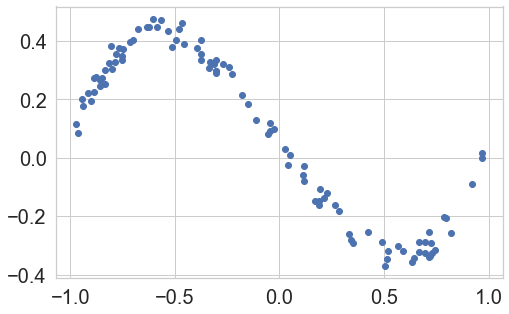

In [88]:
np.random.seed(19)
eps=np.random.rand(100);
m = 100;
t=-1+2*np.random.rand(m,1);
y=t**3-t+0*0.4/(1+25*t**2)+0.1*np.random.rand(m,1);
plt.figure(figsize=(8,5))
plt.scatter(t,y)
plt.tick_params(labelsize=fs-4)

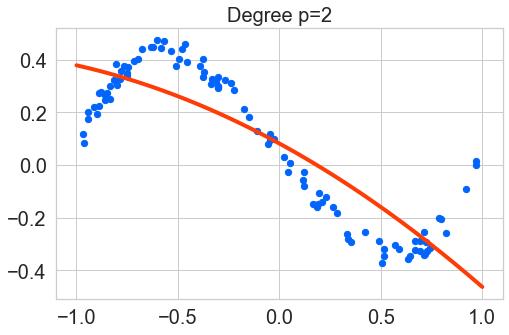

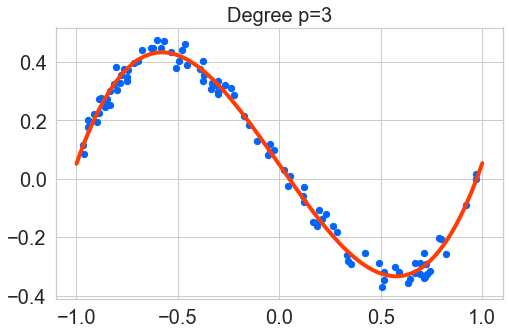

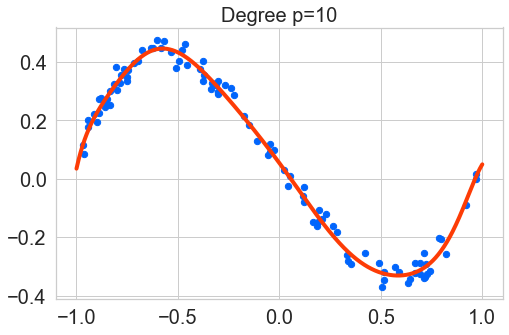

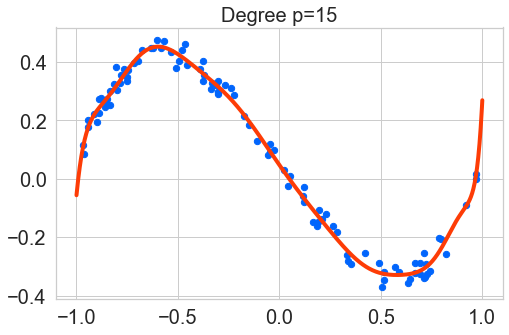

In [141]:
theta = []
eval_theta = []
As = []
tlin=np.linspace(-1,1, 1000)
for p in [2,3,10,15]:
    As.append(polyvander(t.flatten(),p))
    theta.append(la.inv(As[-1].T@As[-1])@As[-1].T@y)
    eval_theta.append(As[-1]@theta[-1])
    plt.figure(figsize=(8,5))
    plt.scatter(t,y, s=40, color='xkcd:bright blue')
    A=polyvander(tlin.flatten(),p)
    plt.plot(tlin, A@theta[-1], linewidth=lw, color='xkcd:red orange')
    plt.tick_params(labelsize=fs-4)
    plt.title('Degree p={}'.format(p), fontsize=fs-4)


## Example 2: Polynomial fit choosing Model order
Now let's see what the relative RMS error looks like on test and training data.

In [144]:
m_train = 1000;
MAXORDER=20
t=-1+2*np.random.rand(m_train,1);
y_train=t**3-t+0.1*0.4/(1+25*t**2)+0.025*np.random.rand(m_train,1);
print("shape y_train : ", np.shape(y_train))
m_test = 100;
t_test = -1 + 2*np.random.rand(m_test,1);
y_test = t_test**3 - t_test + 0.1*0.4/ (1 + 25*t_test**2) + 0.025*np.random.randn(m_test,1);
print("shape y_test  : ", np.shape(y_test))

error_train = np.zeros(MAXORDER);
error_test = np.zeros(MAXORDER);
for p in range(0,MAXORDER):
    A = polyvander(t.flatten(),p+1)
    theta = la.inv(A.T@A)@A.T@y_train
    error_train[p] = la.norm(A@theta - y_train) / la.norm(y_train)
    error_test[p] = la.norm( polyvander(t_test.flatten(), p+1) @ theta - y_test) / la.norm(y_test);

shape y_train :  (1000, 1)
shape y_test  :  (100, 1)


Text(0, 0.5, 'Relative RMS error')

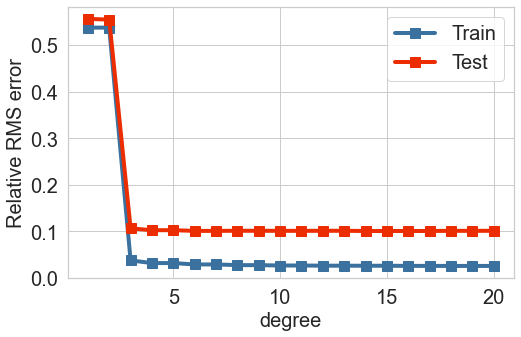

In [146]:
plt.figure(figsize=(8,5))
plt.grid(True)
plt.plot(range(1,MAXORDER+1), error_train, label = "Train", marker ='s', markersize=10,linewidth=lw, color='xkcd:muted blue')
plt.plot(range(1,MAXORDER+1), error_test, label = "Test", marker ='s', markersize=10,linewidth=lw, color='xkcd:tomato red')
plt.legend(fontsize=fs-4)
plt.tick_params(labelsize=fs-4)
plt.xlabel('degree', fontsize=fs-4)
plt.ylabel('Relative RMS error', fontsize=fs-4)

## Example 3: Housing Price Data

In this example we model the house prices as a function of the number of beds and the area. We explore the use of cross-validation. 

In [151]:
df=pd.read_csv("../data/housing.csv")
df.head()

,area,baths,beds,condo,location,price
0,0.941,2,2,1,2,94.905
1,1.146,2,3,0,2,98.937
2,0.909,2,3,0,2,100.309
3,1.289,2,3,0,3,106.250
4,1.020,1,3,0,3,107.502


In [206]:
np.random.seed(10)
price = df["price"]; 
area  = np.asarray(df["area"]); 
beds  = np.asarray(df["beds"]);
n = len(price);
X = np.hstack((np.hstack(( np.ones(n).reshape(n,1), area.reshape(n,1))), beds.reshape(n,1)));
nfold = int(n/5); # size of first four folds
print("size of first four folds : ", nfold)

I = np.random.permutation(n) # random permutation of numbers 1...nfolds
coeff  = np.zeros((5,3)) 
errors = np.zeros((5,2))

size of first four folds :  154


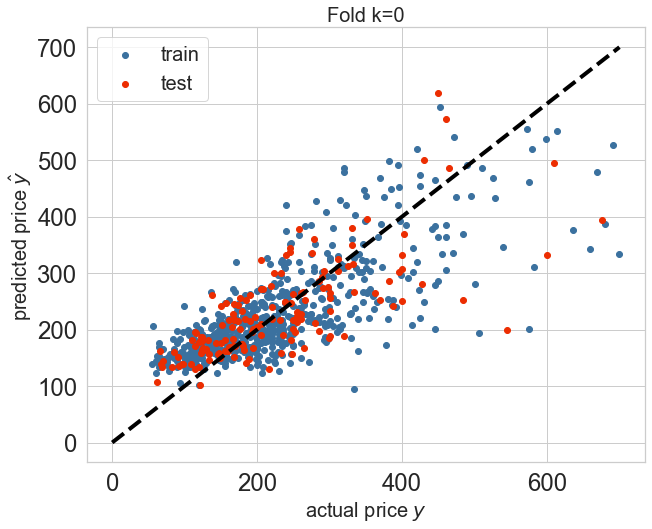

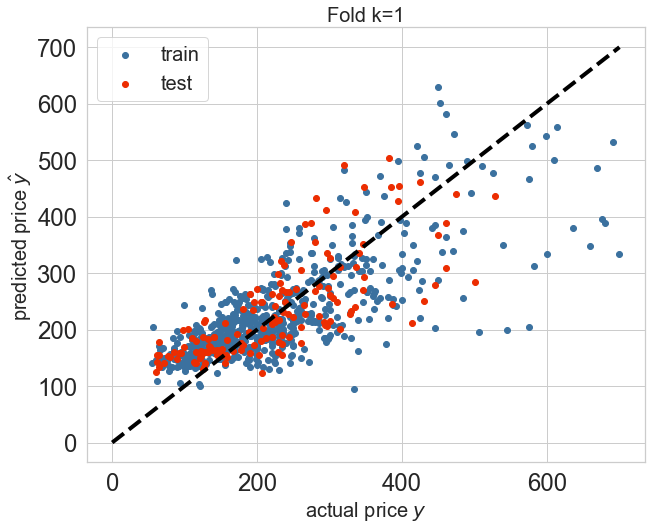

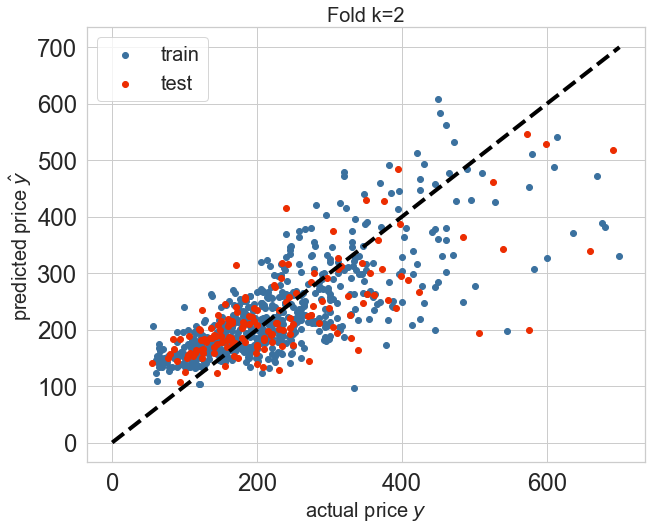

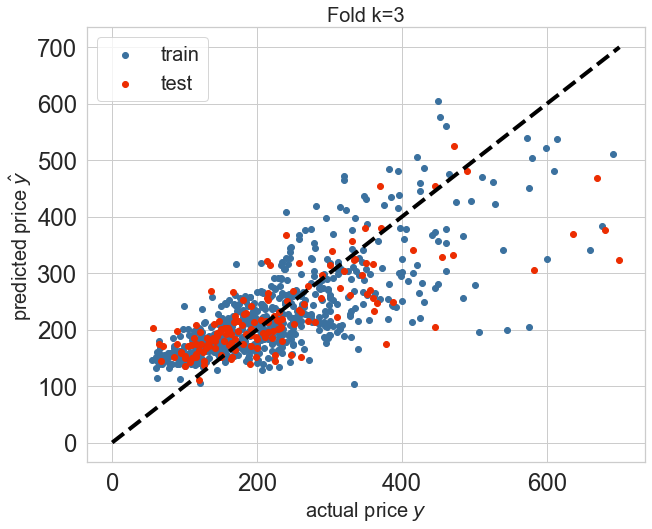

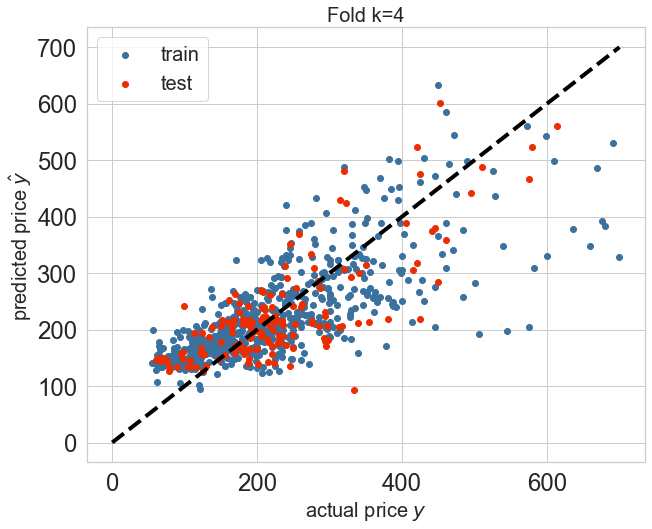

In [264]:
rms_train = {}
rms_const ={}
rms_test = {}
coeff={}
for k in range(0,5):
    if k == 0:
        Itrain = I[nfold::];
        Itest = I[0:nfold];
        #print(np.shape(Itest))
        #break
    elif k == 4:
        Itrain = I[0:4*nfold];
        Itest = I[4*nfold::];
    else:
        Itrain = np.concatenate((I[0:k*nfold],I[(k+1)*nfold::]))
        Itest = I[k*nfold:(k+1)*nfold]

    n_train = len(Itrain)
    n_test = len(Itest)
    #print(X[Itrain,:])
    A=X[Itrain.tolist(),:]
    b=price[Itrain]
    v=np.mean(price[Itrain])
    theta = la.lstsq(A,b, rcond=None)[0] 

    coeff[k] = theta;
    y_train=A@ theta
    rms_train[k] = rms(A@ theta - b);#
    A=X[Itest,:]
    yhat=A @ theta 
    rms_test[k] = rms(yhat- price[Itest])
    rms_const[k] = rms(v-price[Itest])
    
    plt.figure(figsize=(10,8))
    plt.grid('True')
    plt.grid(True)
    plt.tick_params(labelsize=fs)
    plt.scatter(price[Itrain],y_train, color='xkcd:muted blue', label='train')
    plt.scatter(price[Itest],yhat, color='xkcd:tomato red', label='test')
    plt.title('Fold k={}'.format(k), fontsize=fs-4)
    plt.ylabel(r'predicted price $\hat{y}$', fontsize=fs-4)
    plt.xlabel(r'actual price ${y}$', fontsize=fs-4)
    prices=np.linspace(0,700)
    plt.legend(fontsize=fs-4)
    plt.plot(prices, prices, '--', color='xkcd:black', linewidth=4)
    #plt.savefig('./figs/housingprices.png', dpi=300, bbox_inches='tight')

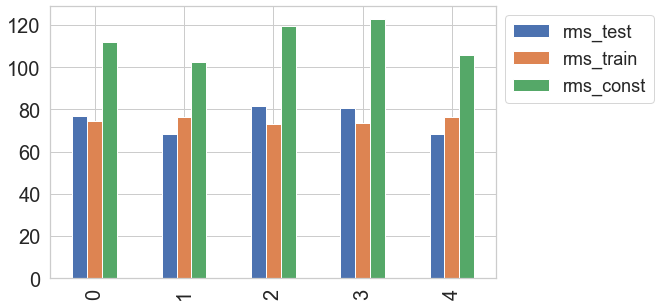

In [265]:

errs={'rms_test':rms_test, 'rms_train':rms_train, 'rms_const':rms_const}
df_errs=pd.DataFrame(errs)
df_errs.plot.bar(figsize=(8,5), fontsize=fs-4)
plt.legend(fontsize=fs-6,loc=0,bbox_to_anchor=(1,1))

In [266]:
vals=0
for k in range(0,5):
    vals+=rms_test[k]**2
print("RMS Cross validation Error : ", np.sqrt(vals/5))

RMS Cross validation Error :  75.33626867448712


### Example 3: Feature Engineering
In this example we exploer feature engineering using the house pricing data.

In [270]:
price = np.asarray(df["price"])
area = np.asarray(df["area"])
beds= np.asarray(df["beds"])
condo= np.asarray(df["condo"])
location= np.asarray(df["location"])

N = len(price)
a = np.vstack(np.ones(N))
b = np.vstack(area)
c = np.vstack([max(i-1.5,0) for i in np.hstack(area)])
d = np.vstack(beds)
e = np.vstack(condo)
f = np.vstack(location == 2).astype(int)
g = np.vstack(location == 3).astype(int)
h = np.vstack(location == 4).astype(int)
X = np.hstack((a,b,c,d,e,f,g,h))
theta = la.lstsq(X,price,rcond=None)[0]
rms(X@theta-price)

68.34428699036884

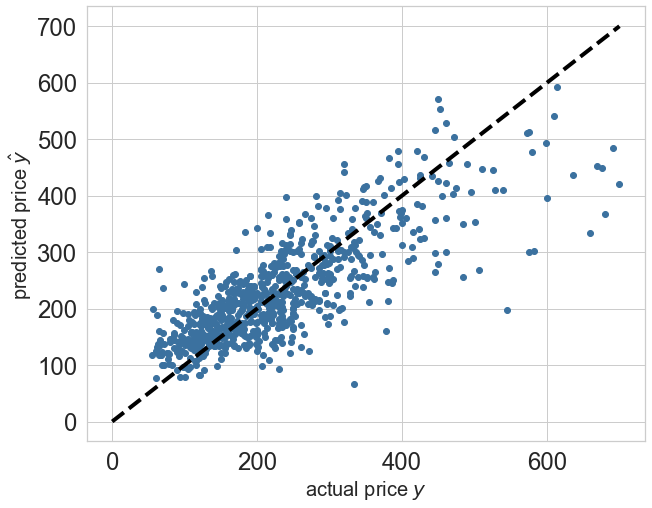

In [273]:
plt.figure(figsize=(10,8))
plt.grid('True')
plt.grid(True)
plt.tick_params(labelsize=fs)
plt.scatter(price,X@theta, color='xkcd:muted blue')
plt.ylabel(r'predicted price $\hat{y}$', fontsize=fs-4)
plt.xlabel(r'actual price ${y}$', fontsize=fs-4)
prices=np.linspace(0,700)
plt.plot(prices, prices, '--', color='xkcd:black', linewidth=4)

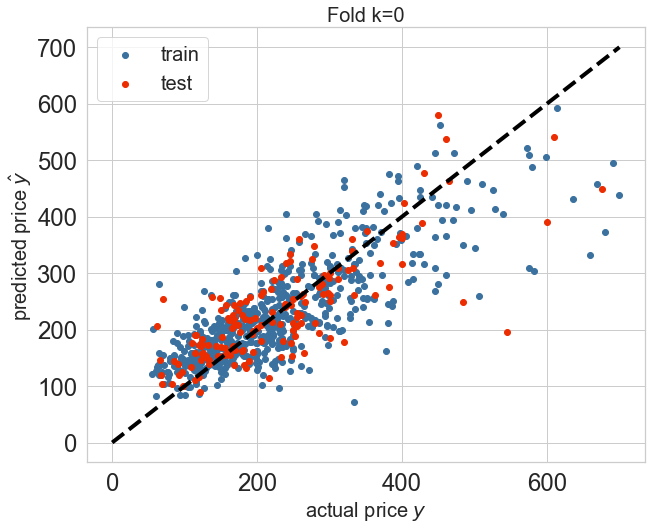

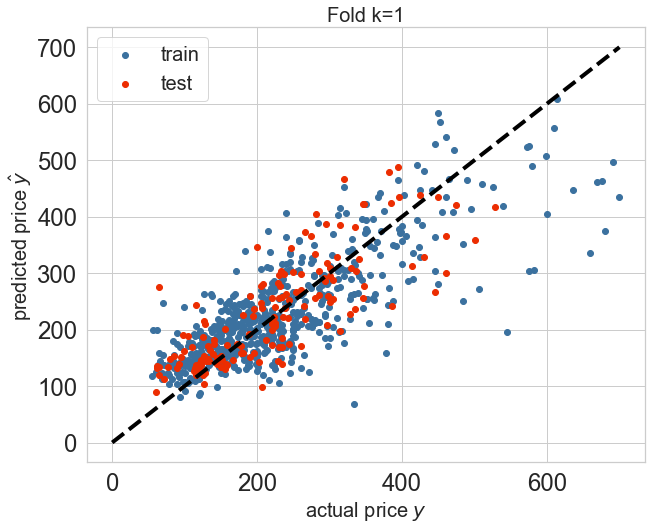

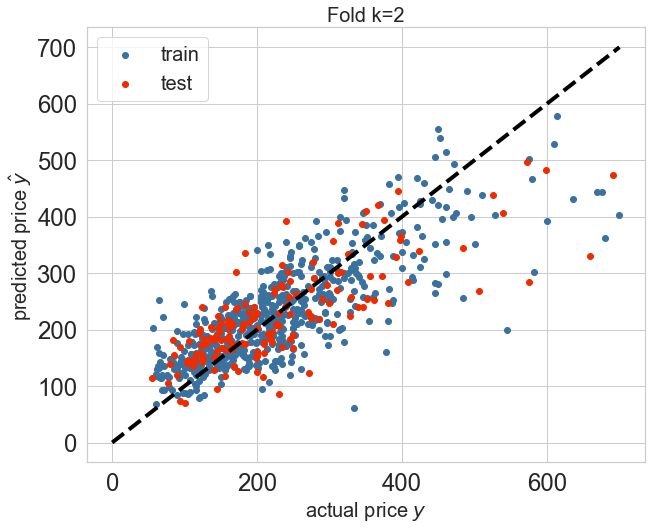

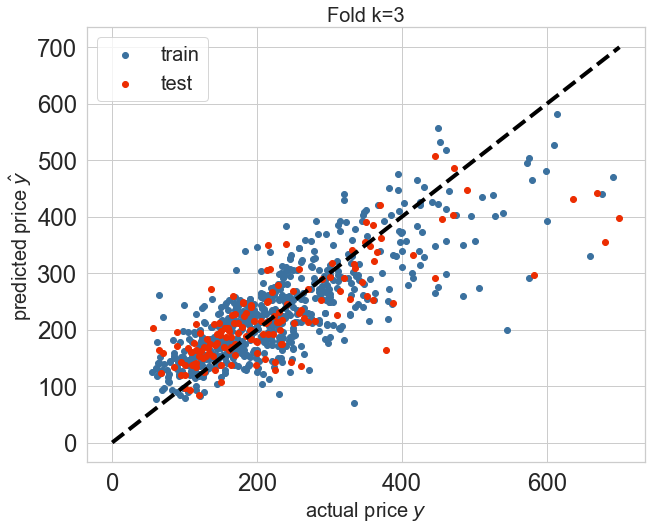

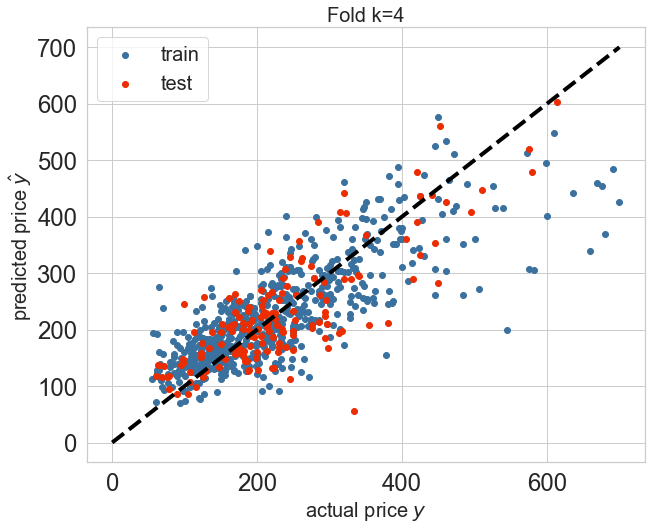

In [274]:
rms_train = {}
rms_const ={}
rms_test = {}
coeff={}
for k in range(0,5):
    if k == 0:
        Itrain = I[nfold::];
        Itest = I[0:nfold];
        #print(np.shape(Itest))
        #break
    elif k == 4:
        Itrain = I[0:4*nfold];
        Itest = I[4*nfold::];
    else:
        Itrain = np.concatenate((I[0:k*nfold],I[(k+1)*nfold::]))
        Itest = I[k*nfold:(k+1)*nfold]

    n_train = len(Itrain)
    n_test = len(Itest)
    #print(X[Itrain,:])
    A=X[Itrain.tolist(),:]
    b=price[Itrain]
    v=np.mean(price[Itrain])
    theta = la.lstsq(A,b, rcond=None)[0] 

    coeff[k] = theta;
    y_train=A@ theta
    rms_train[k] = rms(A@ theta - b);#
    A=X[Itest,:]
    yhat=A @ theta 
    rms_test[k] = rms(yhat- price[Itest])
    rms_const[k] = rms(v-price[Itest])
    
    plt.figure(figsize=(10,8))
    plt.grid('True')
    plt.grid(True)
    plt.tick_params(labelsize=fs)
    plt.scatter(price[Itrain],y_train, color='xkcd:muted blue', label='train')
    plt.scatter(price[Itest],yhat, color='xkcd:tomato red', label='test')
    plt.title('Fold k={}'.format(k), fontsize=fs-4)
    plt.ylabel(r'predicted price $\hat{y}$', fontsize=fs-4)
    plt.xlabel(r'actual price ${y}$', fontsize=fs-4)
    prices=np.linspace(0,700)
    plt.legend(fontsize=fs-4)
    plt.plot(prices, prices, '--', color='xkcd:black', linewidth=4)

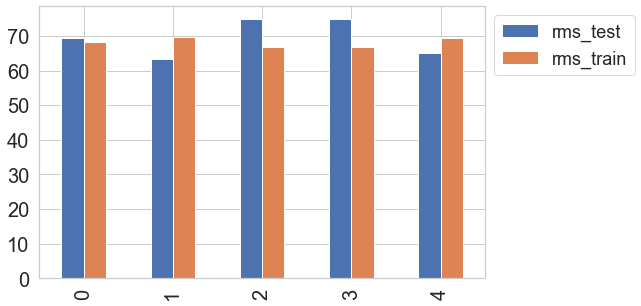

In [276]:

errs={'rms_test':rms_test, 'rms_train':rms_train}
df_errs=pd.DataFrame(errs)
df_errs.plot.bar(figsize=(8,5), fontsize=fs-4)
plt.legend(fontsize=fs-6,loc=0,bbox_to_anchor=(1,1))